In [2]:
import os
import tempfile
import scanpy as sc
import scvi
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker
from scipy.io import mmread
import pandas as pd
import numpy as np
import anndata
import pymde

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sp_exp = mmread("/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_intersectgene_qc_count_1117_sepleu.mtx")
sp_exp = sp_exp.tocsc()

In [4]:
#metadata
meta_update = pd.read_csv("/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_merge_qc_1117_intersectgene_mapct_sepleu_meta.csv", index_col=0)
meta_update

/tmp/slurmtmp.24740206/ipykernel_12680/472158866.py:2: DtypeWarning: Columns (5,8,13,15,16,17,18,19,20,22,25,26,27,28,30,34) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_update = pd.read_csv("/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_merge_qc_1117_intersectgene_mapct_sepleu_meta.csv", index_col=0)


,orig.ident,nCount_RNA,nFeature_RNA,Study_name,Vendor,Species,Strain,Mice_number,Sex,Age,...,Gene_naming_format,Cell_type_annotation,previous_celltype,previous_subcelltype,percent.mt,harmonized_majorct,nCount_integrated,nFeature_integrated,purestudy_name,harmonized_majorct2
SCI00101_AAACCCAGTATGTCAC_1_1,SCI00101,2115,1118,Popovich_2022,Jackson Laboratories (RRID: ISMR_JAX:000664),Mouse,C57BL/6 J,3-4 mice,Female,8-10 weeks,...,Gene symbol,Yes,Microglia,Homeostatic 1,0.000000,Microglia,0,0,Popovich_2022,Microglia
SCI00101_AAACCCAGTCGACGCT_1_1,SCI00101,1826,974,Popovich_2022,Jackson Laboratories (RRID: ISMR_JAX:000664),Mouse,C57BL/6 J,3-4 mice,Female,8-10 weeks,...,Gene symbol,Yes,Pericytes,Unknown,0.000000,Pericytes,0,0,Popovich_2022,Pericytes
SCI00101_AAACGAAAGCGACTGA_1_1,SCI00101,2038,1040,Popovich_2022,Jackson Laboratories (RRID: ISMR_JAX:000664),Mouse,C57BL/6 J,3-4 mice,Female,8-10 weeks,...,Gene symbol,Yes,Microglia,Homeostatic 1,0.000000,Microglia,0,0,Popovich_2022,Microglia
SCI00101_AAACGAAGTGACGCCT_1_1,SCI00101,3787,1586,Popovich_2022,Jackson Laboratories (RRID: ISMR_JAX:000664),Mouse,C57BL/6 J,3-4 mice,Female,8-10 weeks,...,Gene symbol,Yes,Microglia,Homeostatic 1,0.000000,Microglia,0,0,Popovich_2022,Microglia
SCI00101_AAACGAATCTGCTTAT_1_1,SCI00101,3804,1682,Popovich_2022,Jackson Laboratories (RRID: ISMR_JAX:000664),Mouse,C57BL/6 J,3-4 mice,Female,8-10 weeks,...,Gene symbol,Yes,Microglia,Homeostatic 1,0.000000,Microglia,0,0,Popovich_2022,Microglia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGAGAATACAC_uninj_sample3,SCI00303,3896,1619,Lee_2021_v3,Jackson Laboratories (000664),Mouse,C57BL/6J,NaN,Female,8-10 weeks,...,Gene symbol,Yes,Endothelial,Unknown,4.782609,Endothelial cells,0,0,Lee_2021,Endothelial cells
TTTGTTGCAGTACTAC_uninj_sample3,SCI00303,12280,3721,Lee_2021_v3,Jackson Laboratories (000664),Mouse,C57BL/6J,NaN,Female,8-10 weeks,...,Gene symbol,Yes,Ependymal,Unknown,5.528310,Ependymal cells,0,0,Lee_2021,Ependymal cells
TTTGTTGGTAAGCAAT_uninj_sample3,SCI00303,7099,3029,Lee_2021_v3,Jackson Laboratories (000664),Mouse,C57BL/6J,NaN,Female,8-10 weeks,...,Gene symbol,Yes,OPC,Unknown,4.882640,Oligodendrocyte lineage,0,0,Lee_2021,Oligodendrocyte lineage
TTTGTTGTCACCTGTC_uninj_sample3,SCI00303,9745,3028,Lee_2021_v3,Jackson Laboratories (000664),Mouse,C57BL/6J,NaN,Female,8-10 weeks,...,Gene symbol,Yes,Endothelial,Unknown,4.623722,Endothelial cells,0,0,Lee_2021,Endothelial cells


In [5]:
gene_name = pd.read_csv("/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_intersectgene_qc_gene_1117_sepleu.csv",index_col=0)

In [6]:
#construct anndata
adata = anndata.AnnData(X=sp_exp)
adata.var = gene_name
adata.var_names=adata.var["gene"]
adata.obs = meta_update
adata.X = adata.X.astype(float)
adata.layers['counts'] = adata.X

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [7]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="purestudy_name",
    subset=True,
)

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [9]:
#use scvi to integrate
scvi.model.SCVI.setup_anndata(adata, batch_key="purestudy_name")
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")
model.train()

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 81/81: 100%|██████████| 81/81 [1:08:17<00:00, 50.50s/it, v_num=1, train_loss_step=957, train_loss_epoch=909]    

`Trainer.fit` stopped: `max_epochs=81` reached.


Epoch 81/81: 100%|██████████| 81/81 [1:08:17<00:00, 50.58s/it, v_num=1, train_loss_step=957, train_loss_epoch=909]


In [15]:
#evaluate latent representation
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()
# cluster
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/sit

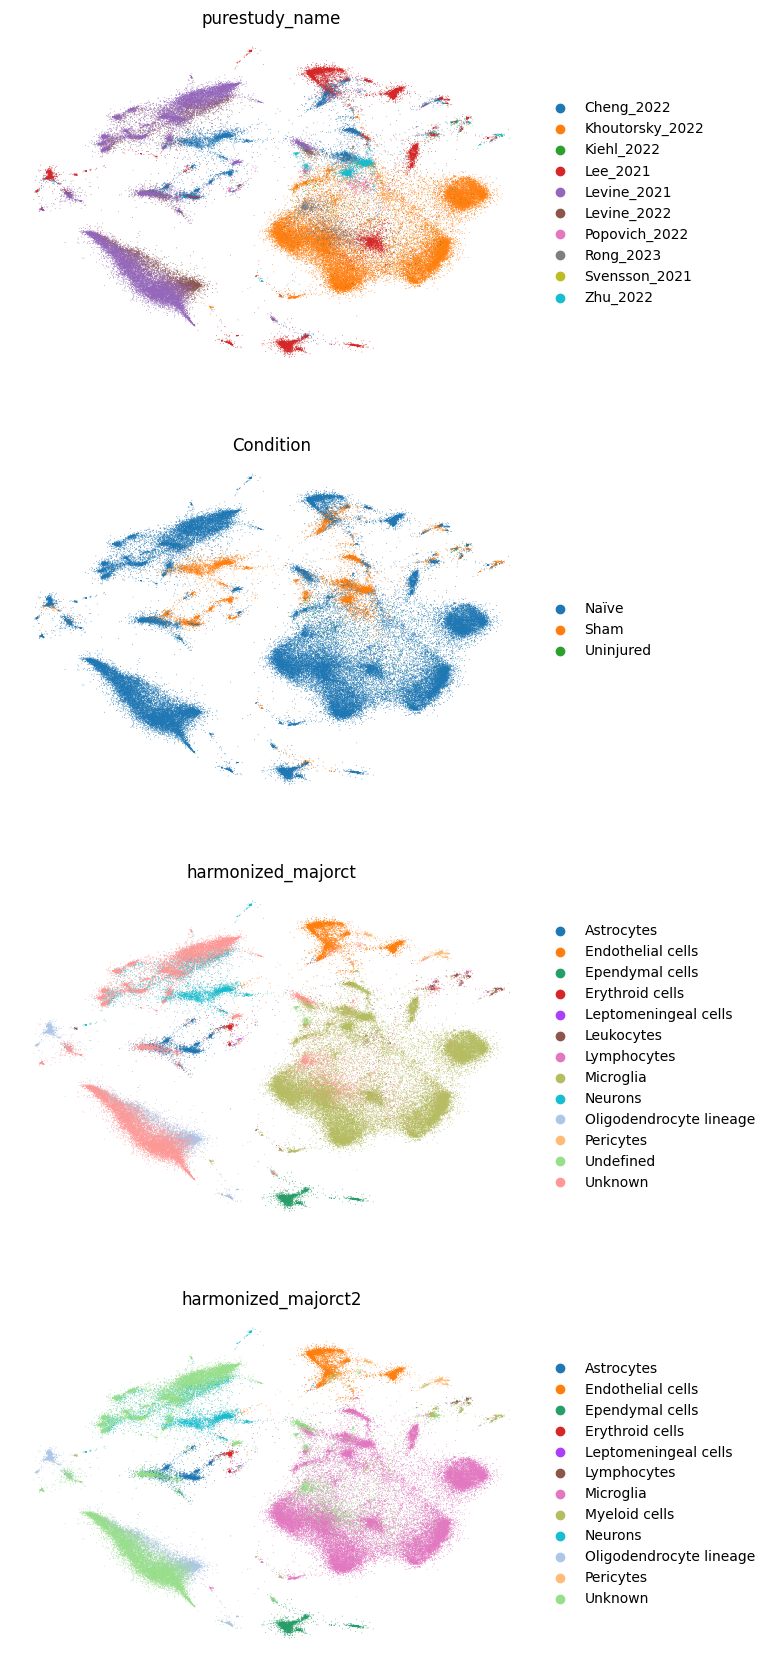

In [16]:
# visualize
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY])
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["purestudy_name","Condition","harmonized_majorct","harmonized_majorct2"],
    frameon=False,
    ncols=1,
)

In [16]:
adata.obs['harmonized_majorct2'].drop_duplicates()

SCI00101_AAACCCAGTATGTCAC_1_1                  Microglia
SCI00101_AAACCCAGTCGACGCT_1_1                  Pericytes
SCI00101_AAACGCTGTATGTGTC_1_1              Myeloid cells
SCI00101_AAAGAACAGGCAGCTA_1_1          Endothelial cells
SCI00101_AAAGGATAGATACTGA_1_1                 Astrocytes
SCI00101_AAAGGATGTACGTGAG_1_1                Lymphocytes
SCI00101_AAAGGATGTGAATATG_1_1            Ependymal cells
SCI00101_AACAGGGAGCCGAACA_1_1            Erythroid cells
SCI00101_AAGGTAACAACTCCCT_1_1       Leptomeningeal cells
SCI00101_AATGGAATCCGATAAC_1_1    Oligodendrocyte lineage
A-45_AAACCTGAGGGTATCG-1_1_1                      Neurons
E2_AAACCCAAGAGGACTC_1_1                          Unknown
Name: harmonized_majorct2, dtype: category
Categories (12, object): ['Astrocytes', 'Endothelial cells', 'Ependymal cells', 'Erythroid cells', ..., 'Neurons', 'Oligodendrocyte lineage', 'Pericytes', 'Unknown']

In [17]:
# more accurate integration result when using scANVI if we have label
# scANVI should be initialized from a scVI model pre-traiAned on the same exact data.
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata, 
    labels_key="harmonized_majorct2",
    unlabeled_category="Unknown",#scANVI can also be used with partially annotated dataset
)
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:101: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 20/20: 100%|██████████| 20/20 [20:50<00:00, 62.33s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=970]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [20:50<00:00, 62.51s/it, v_num=1, train_loss_step=1.05e+3, train_loss_epoch=970]


In [18]:
#retrieve the latent space
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [19]:
#visualize the latent space as well as the inferred labels
SCANVI_MDE_KEY = "X_scANVI_MDE"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY])

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/sit

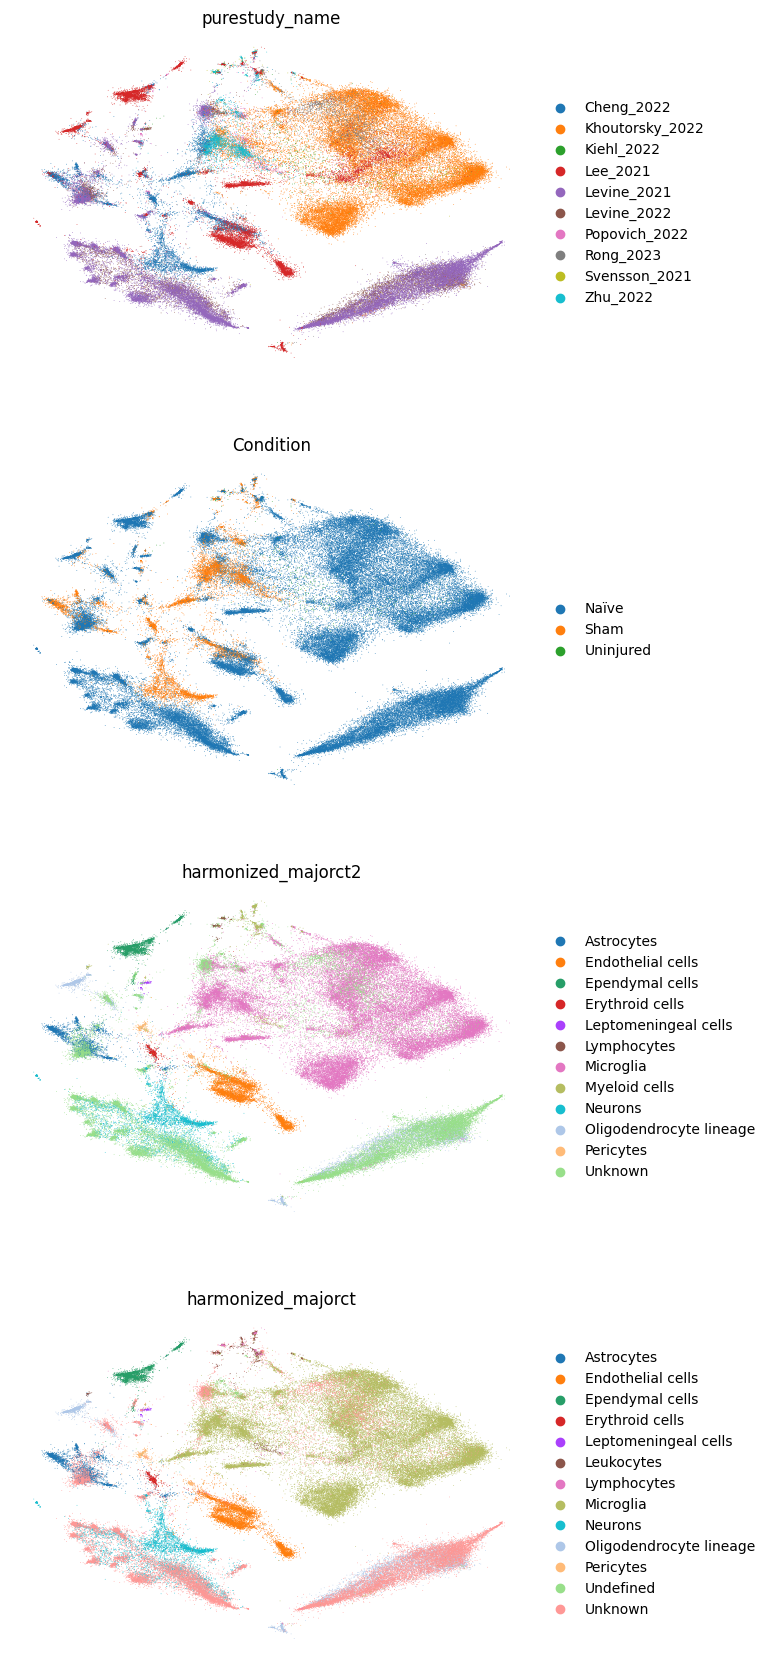

In [22]:
sc.pl.embedding(
    adata, basis=SCANVI_MDE_KEY, color=["purestudy_name","Condition","harmonized_majorct2","harmonized_majorct"], ncols=1, frameon=False
)

In [23]:
adata.obs['Mice_number'] = adata.obs['Mice_number'].astype(str)
adata.write('/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_scanvi_1117_sepleu.h5ad')

In [24]:
#add pca
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key="purestudy_name")
sc.tl.pca(adata, n_comps=30, use_highly_variable=True)

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:484: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA col

In [25]:
from harmony import harmonize
adata.obsm["Harmony"] = harmonize(adata.obsm["X_pca"], adata.obs, batch_key="purestudy_name")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


In [26]:
import pyliger

bdata = adata.copy()
# Pyliger normalizes by library size with a size factor of 1
# So here we give it the count data
batch_cats = adata.obs.purestudy_name.cat.categories
bdata.X = bdata.layers["counts"]
# List of adata per batch
adata_list = [bdata[bdata.obs.purestudy_name == b].copy() for b in batch_cats]
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_cats[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)


liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)


adata.obsm["LIGER"] = np.zeros((adata.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_cats):
    adata.obsm["LIGER"][adata.obs.purestudy_name == b] = liger_data.adata_list[i].obsm["H_norm"]

/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
/users/PAS1475/guoqi/.conda/envs/scvi-env-0926/lib/python3.9/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
100%|██████████| 30/30 [10:42<00:00, 21.41s/it]


In [27]:
#evaluate integration performance
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]
#adata.X = adata.X.astype(float)
bm = Benchmarker(
    adata,
    batch_key="purestudy_name",
    label_key="harmonized_majorct2",
    embedding_obsm_keys=["Unintegrated", "LIGER", "Harmony", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=5,
)
bm.benchmark()

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]INFO:root:isolated labels: no more than 2 batches per label

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]INFO:root:isolated labels: no more than 2 batches per label

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]INFO:root:isolated labels: no more than 2 batches per label

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]
                                                                                         
Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]INFO:root:isolated labels: no more than 2 batches per label

Metrics:   0%|

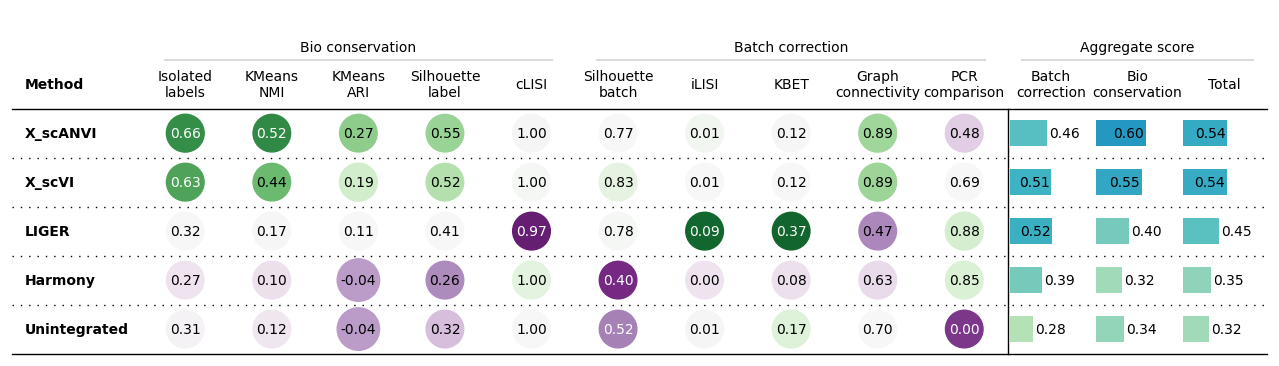

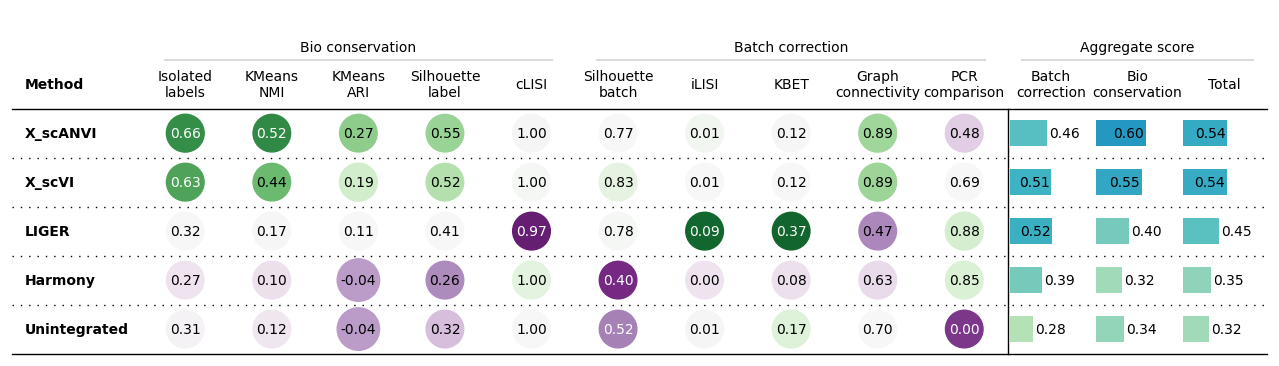

In [30]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
adata.obs['Mice_number'] = adata.obs['Mice_number'].astype(str)
#save
adata.write('/fs/ess/PAS1475/guoqi/sci_atlas/raw_data/Merge_health/health_scanvi_1117_sepleu.h5ad')

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

... storing 'orig.ident' as categorical
... storing 'Study_name' as categorical
... storing 'Vendor' as categorical
... storing 'Species' as categorical
... storing 'Strain' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Tissue' as categorical
... storing 'Spinal_cord_removed_level' as categorical
... storing 'Sample_location_description' as categorical
... storing 'Condition' as categorical
... storing 'Meninges_removal' as categorical
... storing 'Perfusion' as categorical
... storing 'Spinal_cord_process_workflow' as categorical
... storing 'Injury_location_(level)' as categorical
... storing 'Injury_severity' as categorical
... storing 'Treatment' as categorical
... storing 'Time_post_injury_(dpi)' as categorical
... storing 'Cell_type_description' as categorical
... storing 'Fresh_or_frozen' as categorical
... storing 'Sequencing_types' as categorical
... storing 'Dissociation' as categorical
... storing 'Sequencing_technology' as cat

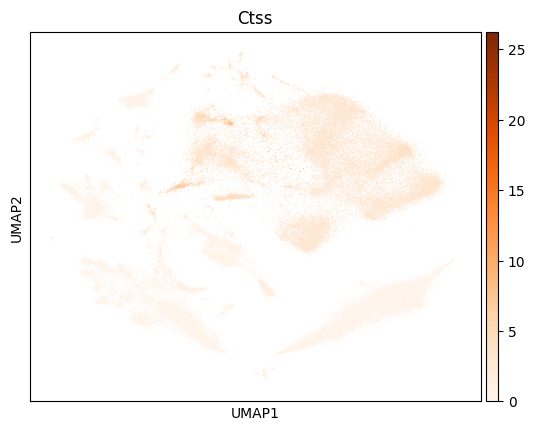

In [33]:
#construct anndata
data = anndata.AnnData(X=sp_exp)
data.var = gene_name
data.var_names=data.var["gene"]
data.obs = meta_update
data.X = data.X.astype(float)
data.layers['counts'] = data.X
data.obsm["umap"] = adata.obsm["X_scANVI_MDE"]

data.var_names = data.var["gene"]


data.var_names_make_unique()
# data.raw = data
# QC
sc.pp.filter_genes(data, min_cells=10)
# Normalization
sc.pp.normalize_total(data, inplace=True)
sc.pp.log1p(data)
sc.pp.normalize_total(data, inplace=True)
figure = sc.pl.umap(data, color="Ctss",cmap="Oranges")

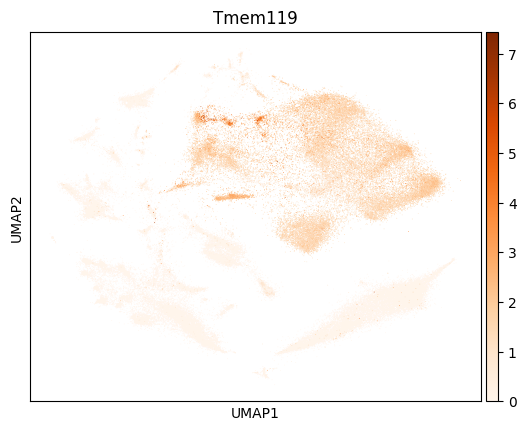

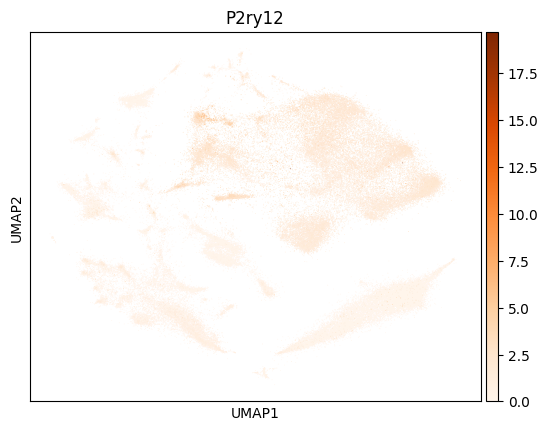

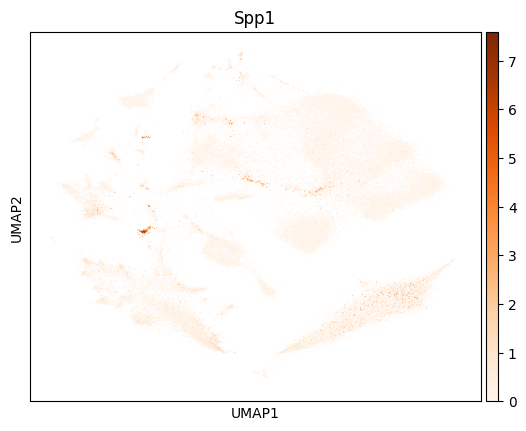

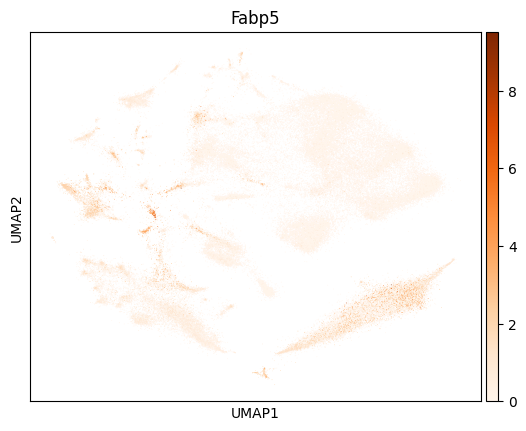

In [35]:
figure = sc.pl.umap(data, color="Tmem119",cmap="Oranges")
figure = sc.pl.umap(data, color="P2ry12",cmap="Oranges")
figure = sc.pl.umap(data, color="Spp1",cmap="Oranges")
figure = sc.pl.umap(data, color="Fabp5",cmap="Oranges")